In [1]:
import os
import re
import string

import einops
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tqdm

from sklearn.decomposition import IncrementalPCA
from pycocotools.coco import COCO
from tensorflow.data import Dataset, AUTOTUNE
from tensorflow.data.experimental import ignore_errors
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import TextVectorization


In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
annotations_path_train = "dataset/annotations_trainval2014/captions_train2014.json"
annotations_path_val = "dataset/annotations_trainval2014/captions_val2014.json"
annotations_path_test = "dataset/annotations_test2014/image_info_test2014.json"

IMAGE_SHAPE=(224, 224, 3)
VOCABULARY_SIZE = 10000

In [4]:
coco_train = COCO(annotations_path_train)
coco_val = COCO(annotations_path_val)
coco_test = COCO(annotations_path_test)

loading annotations into memory...
Done (t=0.26s)
creating index...
index created!
loading annotations into memory...
Done (t=0.13s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [5]:
image_id = coco_train.getImgIds()[1000]
ann_ids = coco_train.getAnnIds(imgIds=image_id)
anns = coco_train.loadAnns(ann_ids)

print(f"Captions for image {image_id}:")
for ann in anns:
    print(ann['caption'])

Captions for image 429437:
a table topped with bowls of food and a glass of water.
Dishes of prepared food laid out on a table with empty glasses and plates
Several bowls of food next to a stack of plates.
Prepared Asian foods sit on a table with dinner plates and glasses.
A black table holds white bowls and plates and different foods as water glasses also sit on the table.


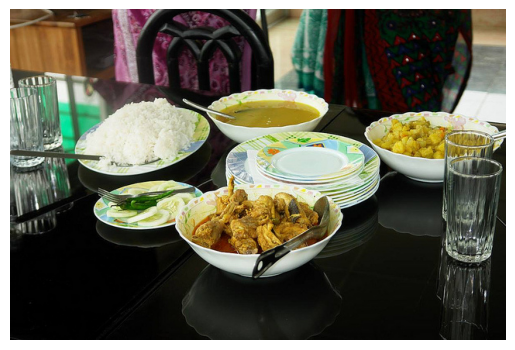

In [6]:
file_name = "COCO_train2014_000000429437.jpg"
img_path = f"dataset/train2014/{file_name}"
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [7]:
def setup_trainval_sets(imgs: str, coco: COCO):
    path_to_imgs = f"dataset/{imgs}/"

    image_paths = []
    captions = []

    image_ids = coco.getImgIds()

    for img_id in image_ids:
        img_metadata = coco.loadImgs(ids=img_id)[0]
        image_path = os.path.join(path_to_imgs, img_metadata['file_name'])
        image_paths.append(image_path)

        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ids=ann_ids)
        for ann in anns:
            captions.append((image_path, ann['caption']))

    image_paths, captions = zip(*captions)
    dataset = tf.data.Dataset.from_tensor_slices((list(image_paths), list(captions)))

    return dataset

In [8]:
def setup_test_set():
    test_images_path = "dataset/test2014/"
    test_image_ids = coco_test.getImgIds()

    test_image_paths = []
    for img_id in test_image_ids:
        img_metadata = coco_test.loadImgs(img_id)[0]
        test_image_paths.append(os.path.join(test_images_path, img_metadata['file_name']))

    test_dataset = tf.data.Dataset.from_tensor_slices(test_image_paths)

    return test_dataset


In [9]:
dataset_train = setup_trainval_sets("train2014", coco_train)
dataset_val = setup_trainval_sets("val2014", coco_val)
dataset_test = setup_test_set()


In [10]:
for ex_path, ex_caption in dataset_train.take(1):
    print("Image path:", ex_path.numpy())
    print("Caption:", ex_caption.numpy())

for ex_path, ex_caption in dataset_val.take(1):
    print("Image path:", ex_path.numpy())
    print("Caption:", ex_caption.numpy())

for ex_path in dataset_test.take(1):
    print("Image path:", ex_path.numpy())


Image path: b'dataset/train2014/COCO_train2014_000000057870.jpg'
Caption: b'A restaurant has modern wooden tables and chairs.'
Image path: b'dataset/val2014/COCO_val2014_000000391895.jpg'
Caption: b'A man with a red helmet on a small moped on a dirt road. '
Image path: b'dataset/test2014/COCO_test2014_000000523573.jpg'


2025-01-17 23:31:07.531681: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-17 23:31:07.534810: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:2])
    img = tf.keras.applications.mobilenet_v3.preprocess_input(img)
    return img


In [12]:
# Image Encoder Layer (Pretrained ResNet50V2 Network)

mobilenet = MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False, # Exclude the classification head
    weights='imagenet',
    pooling=None)

mobilenet.trainable=False

In [13]:
# Tokenizer

def standardize(s):
  s = tf.strings.lower(s) # Lowercase
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '') # Remove puncuation
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ') # Add [START] and [END] tokens to the text
  return s

tokenizer = TextVectorization(
  max_tokens=VOCABULARY_SIZE,
  standardize=standardize,
  output_sequence_length=50,
  ragged=True
)

In [14]:
tokenizer.adapt(dataset_train.map(lambda img_path, caption: caption).batch(1024))

2025-01-17 23:31:09.092380: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
tokenizer.get_vocabulary()[:10]

['',
 '[UNK]',
 np.str_('a'),
 np.str_('[START]'),
 np.str_('[END]'),
 np.str_('on'),
 np.str_('of'),
 np.str_('the'),
 np.str_('in'),
 np.str_('with')]

In [16]:
t = tokenizer([['a large wooden cat'], ['a table on a hill']])
t

<tf.RaggedTensor [[3, 2, 29, 99, 51, 4], [3, 2, 24, 5, 2, 224, 4]]>

In [17]:
# Mappings for words to indices and indices to words

word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary()
)

index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True
)

In [18]:
w = index_to_word(t)
w.to_list()

tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

array([b'[START] a large wooden cat [END]',
       b'[START] a table on a hill [END]'], dtype=object)

In [19]:
# Function to extend each caption to an image (duplicate)

def split_captions_on_images(images, captions):
    # Parse captions (b: batch size, c: captions)
    caption_shape = einops.parse_shape(captions, 'b c')
    # Flatten captions to match repeated images
    captions = einops.rearrange(captions, 'b c -> (b c)')
    # Repeat the images along the caption dimension
    images = einops.repeat(images, 'b ... -> (b c) ...', c=caption_shape['c'])

    return images, captions

In [20]:
def prepare_text(images, texts):
    tokens = tokenizer(texts)

    # Shift tokens for input and labels
    input_tokens = tokens[..., :-1]  # All tokens except the last one (input for prediction)
    label_tokens = tokens[..., 1:]   # All tokens except the first one (target output)

    return (images, input_tokens), label_tokens

In [21]:
def process_image_and_caption(img_path, caption):
    # Load the image and tokenize the caption
    image = load_image(img_path)
    tokenized_caption = tokenizer(caption)
    return image, tokenized_caption


def to_tensor(inputs, labels):
    (images, input_tokens), label_tokens = inputs, labels
    return (images, input_tokens.to_tensor()), label_tokens.to_tensor()


def prepare_dataset(dataset: Dataset, tokenizer, batch_size=256, shuffle_buffer=1000):
    dataset = (
        dataset
        .shuffle(10000)
        .map(process_image_and_caption, num_parallel_calls=AUTOTUNE)
        .apply(ignore_errors())
        .batch(batch_size)
    )

    return (
        dataset
        .map(split_captions_on_images, AUTOTUNE)
        .unbatch()
        .shuffle(shuffle_buffer)
        .batch(batch_size)
        .map(prepare_text, AUTOTUNE)
        .map(to_tensor, AUTOTUNE)
    )

In [22]:
train_ds = prepare_dataset(dataset_train, tokenizer)
train_ds.element_spec

val_ds = prepare_dataset(dataset_val, tokenizer)
val_ds.element_spec

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [25]:
"""
def fit_incremental_pca(dataset, image_model, n_components=256, batch_size=32):
    ipca = IncrementalPCA(n_components=n_components)
    for (images, _) in tqdm.tqdm(dataset.batch(batch_size)):
        feature_maps = image_model(images)
        ipca.partial_fit(feature_maps.numpy())  # Update PCA incrementally

    return ipca
"""
def fit_incremental_pca(dataset, image_model, n_components=256, batch_size=256):
    ipca = IncrementalPCA(n_components=n_components)

    # Preprocess dataset: Load and process images
    dataset = (
        dataset
        .map(lambda img_path, caption: (load_image(img_path), caption),
             num_parallel_calls=tf.data.AUTOTUNE)  # Load and preprocess images in parallel
        .batch(batch_size)  # Batch the dataset
        .prefetch(tf.data.AUTOTUNE)  # Prefetch to improve pipeline performance
    )

    # Process each batch and update PCA
    for images, _ in tqdm.tqdm(dataset):
        feature_maps = image_model(images)  # Extract feature maps using MobileNet
        feature_maps = tf.reshape(feature_maps, [feature_maps.shape[0], -1])  # Flatten 4D to 2D
        ipca.partial_fit(feature_maps.numpy())  # Update PCA incrementally

    return ipca

ipca = fit_incremental_pca(dataset_train, image_model=mobilenet)

 43%|████▎     | 691/1618 [36:51<49:26,  3.20s/it]   


KeyboardInterrupt: 

In [ ]:
def gen(dataset, image_model):
    for (images, captions) in tqdm.tqdm(dataset):
        feature_maps = image_model(images)
        reduced_features = ipca.transform(feature_maps.numpy())  # Apply PCA
        yield reduced_features, captions


def save_dataset(dataset, save_path, image_model, shards=10, batch_size=256):
    dataset = (
        dataset
        .map(lambda img_path, caption: (load_image(img_path), caption))
        .apply(ignore_errors())
        .batch(batch_size)
    )

    new_dataset = Dataset.from_generator(
        lambda: gen(dataset, image_model),
        output_signature=(
            tf.TensorSpec(shape=(ipca.n_components,), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.string)
        )
    )

    new_dataset = (
        new_dataset
        .map(prepare_text, num_parallel_calls=AUTOTUNE)
        .unbatch()
        .shuffle(1000)
    )

    def shard_func(i, item):
        return i % shards

    new_dataset.enumerate().save(save_path, shard_func=shard_func)

In [ ]:
save_dataset(dataset_train, "processed_dataset/train2014_cache", mobilenet)

In [ ]:
def custom_reader_func(datasets, cycle_length=2):
    datasets = datasets.shuffle(1000)
    return datasets.interleave(lambda x: x, cycle_length=cycle_length)


def drop_index(i, x):
    return x


def load_dataset(save_path, batch_size=256, shuffle=1000, cycle_length=2):
    dataset = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

    dataset = (
        dataset
        .map(drop_index, tf.data.AUTOTUNE)
        .shuffle(shuffle)
        .padded_batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    return dataset